Padraig Punch 8487103

Using Google Colab some installs

In [1]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [2]:
!pip install kneed

Import Python Modules and Dataset

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder #needed for data preparation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from feature_engine.creation import CyclicalFeatures
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

Load the dataset

In [66]:
df = pd.read_csv("./bank.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


In [67]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [68]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

Map month and use cyclical features on day and month then drop day and month, they are replaced by there cos and sin

In [69]:
scale_mapper_month = {
"jan":        1,
"feb":        2,
"mar":        3,
"apr":        4,
"may":        5,
"jun":        6,
"jul":        7,
"aug":        8,
"sep":        9,
"oct":       10,
"nov":       11,
"dec":       12
}
df['month'] = df['month'].replace(scale_mapper_month)

cyclical = CyclicalFeatures(variables=None, drop_original=False)
df1 = df[['day','month']].copy()
df1 = cyclical.fit_transform(df1)
day_sin = df1['day_sin']
df = pd.concat([df,day_sin],axis=1)
day_cos = df1['day_cos']
df = pd.concat([df,day_cos],axis=1)
month_sin = df1['month_sin']
df = pd.concat([df,month_sin],axis=1)
month_cos = df1['month_cos']
df = pd.concat([df,month_cos],axis=1)

df = df.drop(['day','month'], axis=1)

print(cyclical.max_values_)

{'day': 31, 'month': 12}


<ipython-input-69-23d5b7640814>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['month'] = df['month'].replace(scale_mapper_month)


In [70]:
df.describe()

age       balance     duration     campaign        pdays  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500   292.020500     1.909500   167.896000   
std      12.724358   3131.224213   221.557295     1.378862   131.754126   
min      18.000000   -980.000000     7.000000     1.000000    -1.000000   
25%      32.000000    201.500000   146.000000     1.000000    75.750000   
50%      38.000000    551.000000   236.000000     1.000000   182.000000   
75%      50.000000   1644.500000   379.000000     2.000000   251.000000   
max      93.000000  81204.000000  1823.000000    11.000000   854.000000   

          previous      day_sin      day_cos    month_sin     month_cos  
count  2000.000000  2000.000000  2000.000000  2000.000000  2.000000e+03  
mean      2.561500     0.200956     0.185124     0.218295 -7.347338e-02  
std       3.400735     0.659767     0.700368     0.685899  6.906266e-01  
min       0.000000    -0.998717    -0.994869    -1.000000 -1.000000e+00  
25%       1.000000    -0.394356    -0.440394    -0.500000 -8.660254e-01  
50%       2.000000     0.394356     0.347305     0.500000 -1.836970e-16  
75%       3.000000     0.848644     0.820763     0.866025  5.000000e-01  
max      55.000000     0.998717     1.000000     1.000000  1.000000e+00

Distribution of the numerical attributes

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>],
       [<Axes: title={'center': 'day_sin'}>,
        <Axes: title={'center': 'day_cos'}>,
        <Axes: title={'center': 'month_sin'}>],
       [<Axes: title={'center': 'month_cos'}>, <Axes: >, <Axes: >]],
      dtype=object)

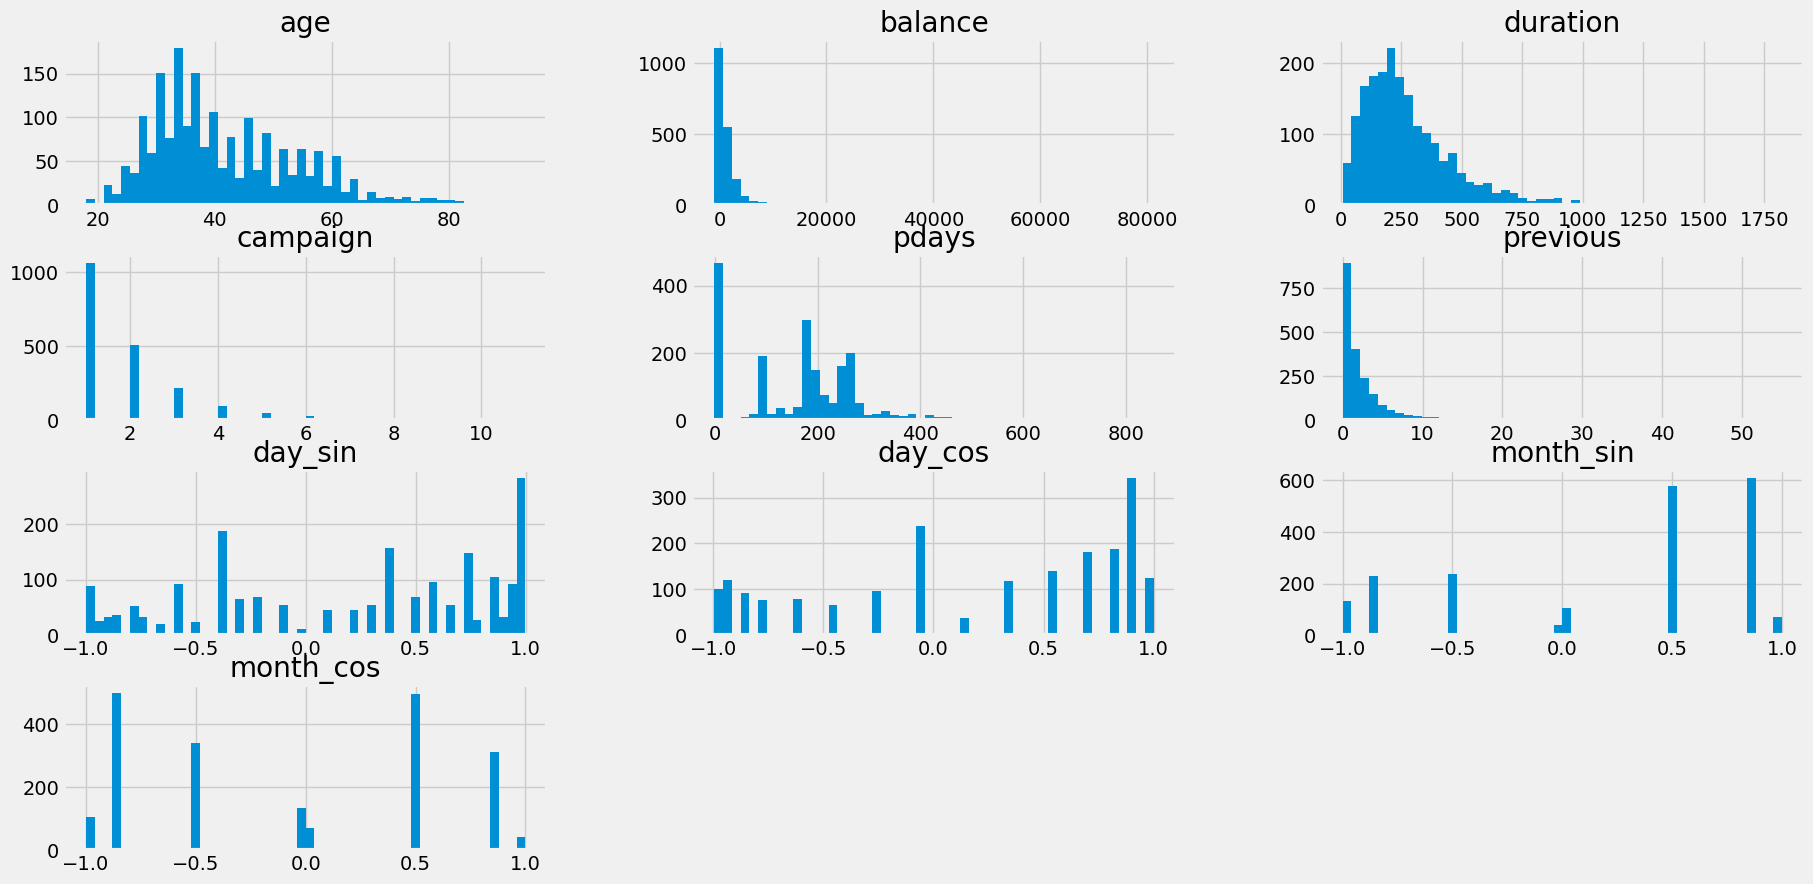

In [71]:
plt.rcParams['figure.figsize'] = (20, 10)
df.hist(bins=50)

<Axes: >

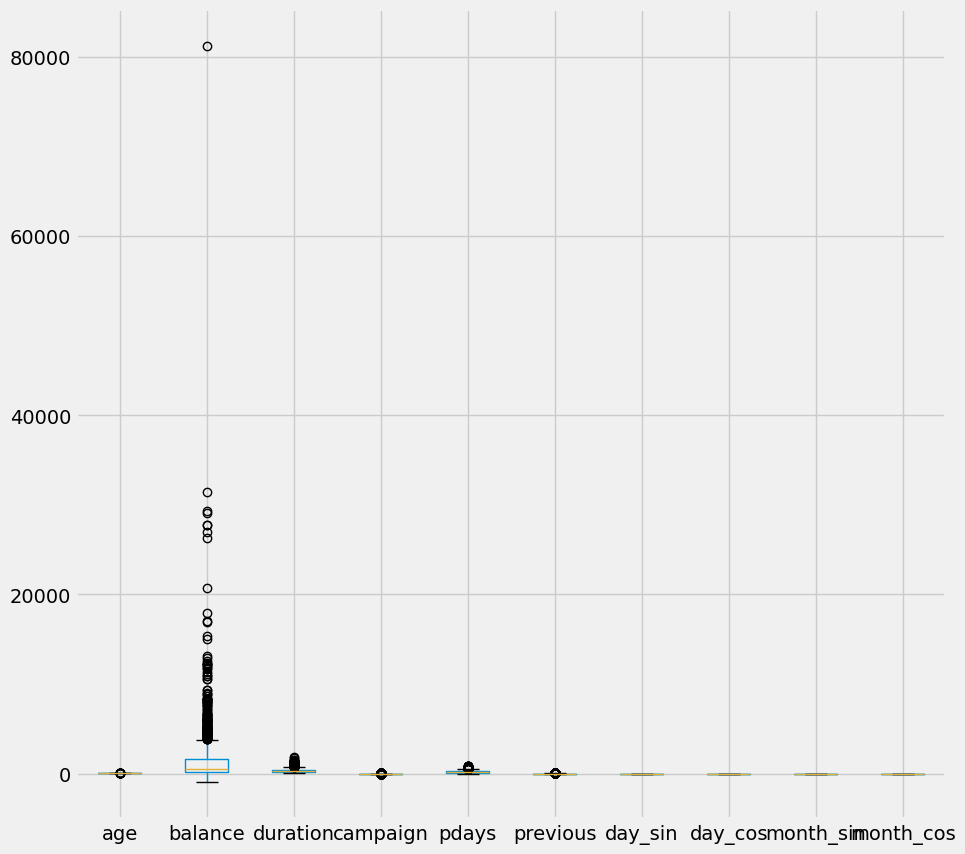

In [72]:
plt.rcParams['figure.figsize'] = (10,10)
df.boxplot()

Check for nulls

In [73]:
df.isna().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
day_sin         0
day_cos         0
month_sin       0
month_cos       0
dtype: int64

Unskew balance and duration

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>],
       [<Axes: title={'center': 'day_sin'}>,
        <Axes: title={'center': 'day_cos'}>,
        <Axes: title={'center': 'month_sin'}>],
       [<Axes: title={'center': 'month_cos'}>,
        <Axes: title={'center': 'balancelog'}>,
        <Axes: title={'center': 'durationlog'}>]], dtype=object)

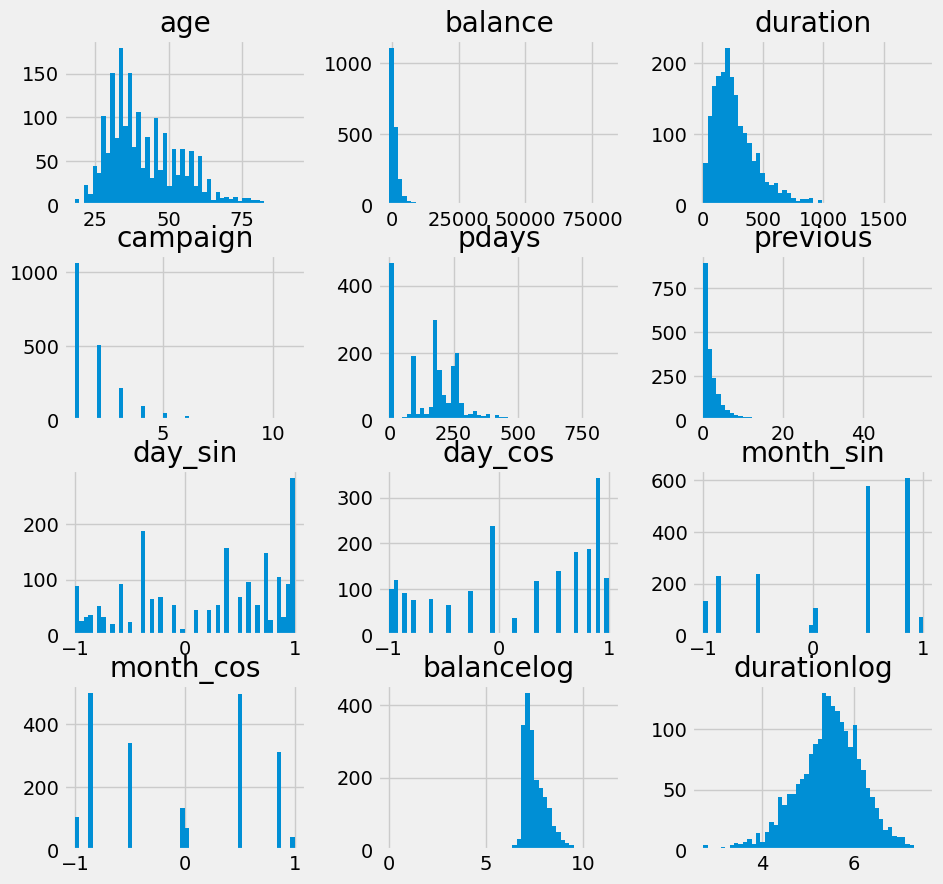

In [74]:
df1 = pd.DataFrame()
df1['balancelog'] = np.log(df['balance'] + abs(min(df['balance'])) + 1)
df = pd.concat([df,df1],axis=1)
df1 = pd.DataFrame()
df1['durationlog'] = np.log(df['duration'] + abs(min(df['duration'])) + 1)
df = pd.concat([df,df1],axis=1)

df.hist(bins=50)

In [75]:
df.describe()


age       balance     duration     campaign        pdays  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500   292.020500     1.909500   167.896000   
std      12.724358   3131.224213   221.557295     1.378862   131.754126   
min      18.000000   -980.000000     7.000000     1.000000    -1.000000   
25%      32.000000    201.500000   146.000000     1.000000    75.750000   
50%      38.000000    551.000000   236.000000     1.000000   182.000000   
75%      50.000000   1644.500000   379.000000     2.000000   251.000000   
max      93.000000  81204.000000  1823.000000    11.000000   854.000000   

          previous      day_sin      day_cos    month_sin     month_cos  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2.000000e+03   
mean      2.561500     0.200956     0.185124     0.218295 -7.347338e-02   
std       3.400735     0.659767     0.700368     0.685899  6.906266e-01   
min       0.000000    -0.998717    -0.994869    -1.000000 -1.000000e+00   
25%       1.000000    -0.394356    -0.440394    -0.500000 -8.660254e-01   
50%       2.000000     0.394356     0.347305     0.500000 -1.836970e-16   
75%       3.000000     0.848644     0.820763     0.866025  5.000000e-01   
max      55.000000     0.998717     1.000000     1.000000  1.000000e+00   

        balancelog  durationlog  
count  2000.000000  2000.000000  
mean      7.510875     5.459587  
std       0.651886     0.728072  
min       0.000000     2.708050  
25%       7.075386     5.036953  
50%       7.334329     5.497168  
75%       7.873027     5.958425  
max      11.316728     7.512618

In [76]:
# First, we define a pipeline consisting of three transforms, applied to age in a sequence.
age_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ("distribution_transform1", FunctionTransformer(func=np.log)),
        ("scaler", RobustScaler())
    ]
)

others_pipeline = Pipeline(
     steps = [
        ("scaler", RobustScaler())
    ]
)

dummy_pipeline = Pipeline(
     steps = [
     ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

ordinal_nan_pipeline = Pipeline(
     steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ("ord_encoder_nan_sub", OrdinalEncoder()),
        ("scaler", StandardScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
    ("age", age_pipeline, ['age']),
    ("others", others_pipeline, ['balancelog','durationlog','campaign','pdays','previous']),
    ("boolean", OneHotEncoder(), ['default','housing', 'loan', 'subscribed']),
    ("ord_encoder_nan", ordinal_nan_pipeline, ['job','marital','education','contact','poutcome']),
    ("dummy", dummy_pipeline, ['day_sin','day_cos','month_sin','month_cos']),
    ],
    remainder =  'drop' #
)


In [77]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
])

Next, we fit the pipeline on the dataset to train a clustering model.

In [78]:
clustering_model = pipe.fit(df)
clustering_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('distribution_transform1',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('others',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['balancelog', 'durationlog',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('...
                                                   'subscribed']),
                                                 ('ord_encoder_nan',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ord_encoder_nan_sub',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome']),
                                                 ('dummy',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['day_sin', 'day_cos',
                                                   'month_sin',
                                                   'month_cos'])]))])

In [79]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)
preprocessed_data

array([[-3.85066599e-01, -1.37374795e-01,  1.49213404e+00, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       [ 5.82035337e-02,  1.07380157e-01, -1.34255741e-02, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       [ 9.85803268e-01,  3.44191918e-01, -6.50403231e-01, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       ...,
       [ 1.69591053e+00,  4.16093082e-01, -2.24691269e-02, ...,
        -9.54139256e-01, -1.00000000e+00, -1.83697020e-16],
       [ 4.28099391e-01,  1.56166931e+00, -2.54460269e-01, ...,
        -6.12105983e-01, -1.00000000e+00, -1.83697020e-16],
       [ 1.14933401e-01,  1.97174190e+00, -1.32277276e-01, ...,
        -2.50652532e-01, -1.00000000e+00, -1.83697020e-16]])

In [80]:
df.describe()

age       balance     duration     campaign        pdays  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500   292.020500     1.909500   167.896000   
std      12.724358   3131.224213   221.557295     1.378862   131.754126   
min      18.000000   -980.000000     7.000000     1.000000    -1.000000   
25%      32.000000    201.500000   146.000000     1.000000    75.750000   
50%      38.000000    551.000000   236.000000     1.000000   182.000000   
75%      50.000000   1644.500000   379.000000     2.000000   251.000000   
max      93.000000  81204.000000  1823.000000    11.000000   854.000000   

          previous      day_sin      day_cos    month_sin     month_cos  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2.000000e+03   
mean      2.561500     0.200956     0.185124     0.218295 -7.347338e-02   
std       3.400735     0.659767     0.700368     0.685899  6.906266e-01   
min       0.000000    -0.998717    -0.994869    -1.000000 -1.000000e+00   
25%       1.000000    -0.394356    -0.440394    -0.500000 -8.660254e-01   
50%       2.000000     0.394356     0.347305     0.500000 -1.836970e-16   
75%       3.000000     0.848644     0.820763     0.866025  5.000000e-01   
max      55.000000     0.998717     1.000000     1.000000  1.000000e+00   

        balancelog  durationlog  
count  2000.000000  2000.000000  
mean      7.510875     5.459587  
std       0.651886     0.728072  
min       0.000000     2.708050  
25%       7.075386     5.036953  
50%       7.334329     5.497168  
75%       7.873027     5.958425  
max      11.316728     7.512618

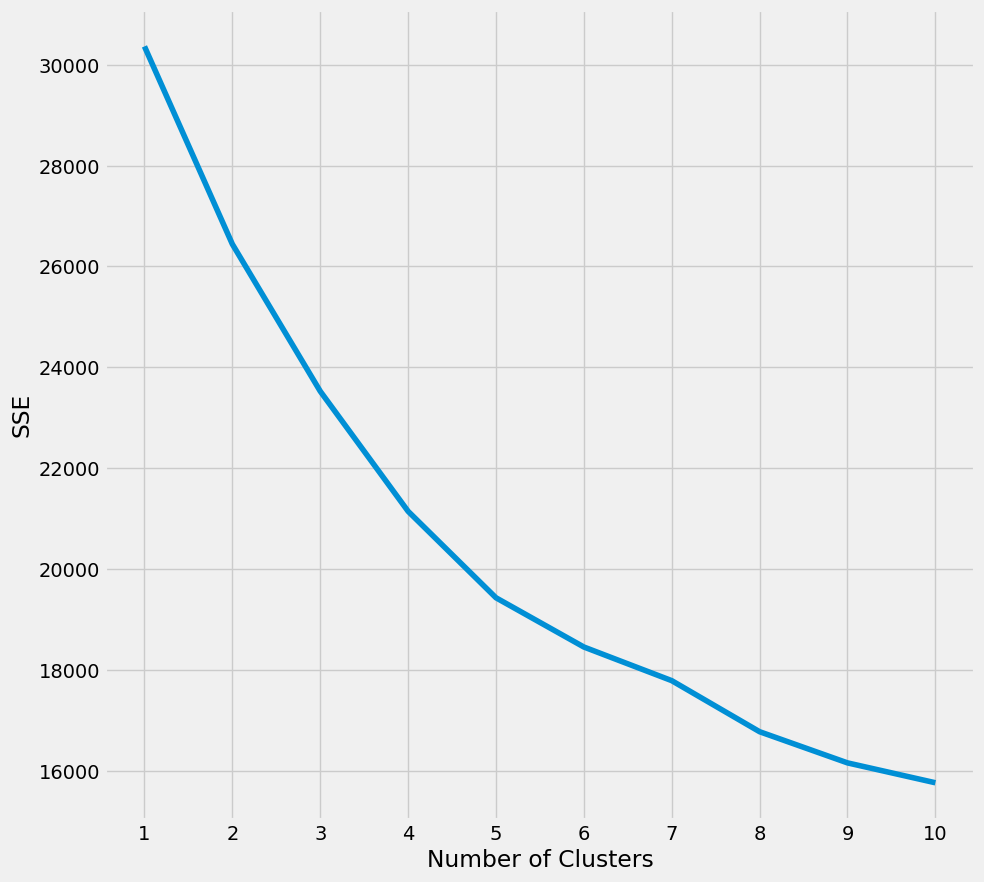

In [81]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_data)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [82]:
kl = KneeLocator(
range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

5

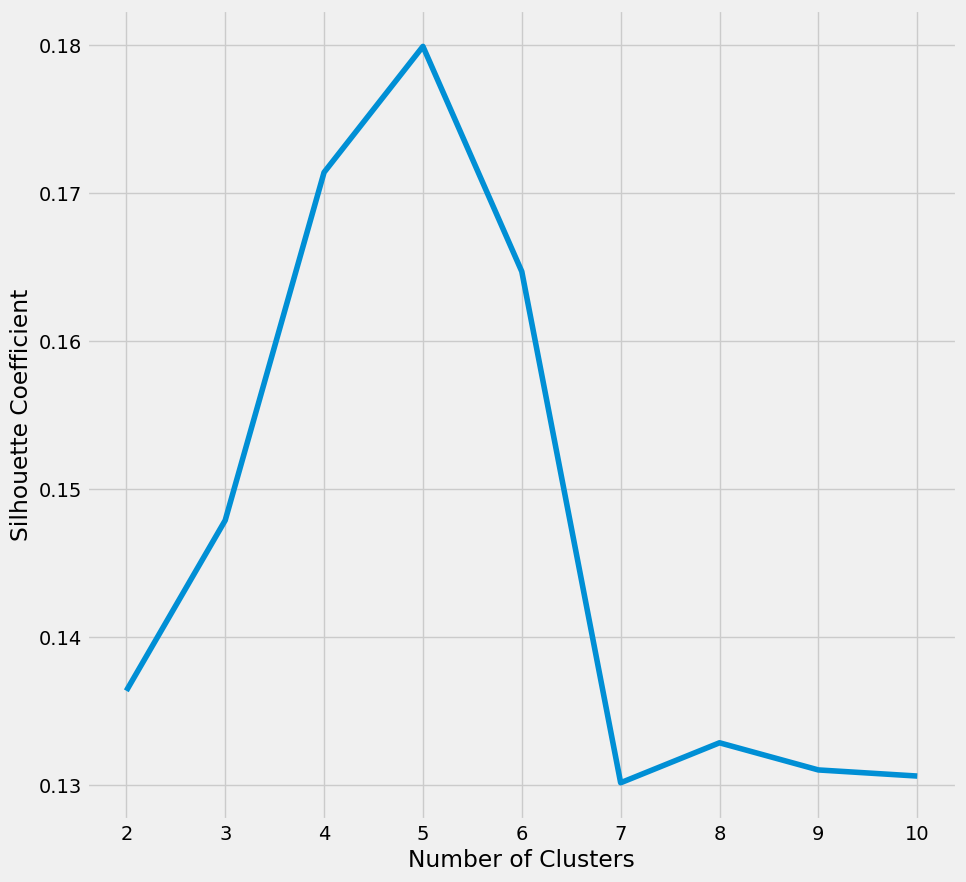

In [83]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_data)
    score = silhouette_score(preprocessed_data, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

At 5 also

Add KMeans to pipeline

In [84]:
k = kl.elbow
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])
clustering_model = pipe.fit(df)
clustering_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('distribution_transform1',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('others',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['balancelog', 'durationlog',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ord_encoder_nan_sub',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'poutcome']),
                                                 ('dummy',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['day_sin', 'day_cos',
                                                   'month_sin',
                                                   'month_cos'])])),
                ('kMeans', KMeans(n_clusters=5, n_init=10))])

Append the cluster centers to the preprocessed dataset.

In [85]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

In [86]:
data_and_centers.shape

(2005, 23)

In [87]:
clustering_model['kMeans'].cluster_centers_.shape

(5, 23)

Project both the data and the k-Means cluster centers to 2D.

In [88]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

transformation complete


The function clustering_scatterplot() creates the 2D scatter plot of the clustered dataset.

In [89]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple', 'gray'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):


    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

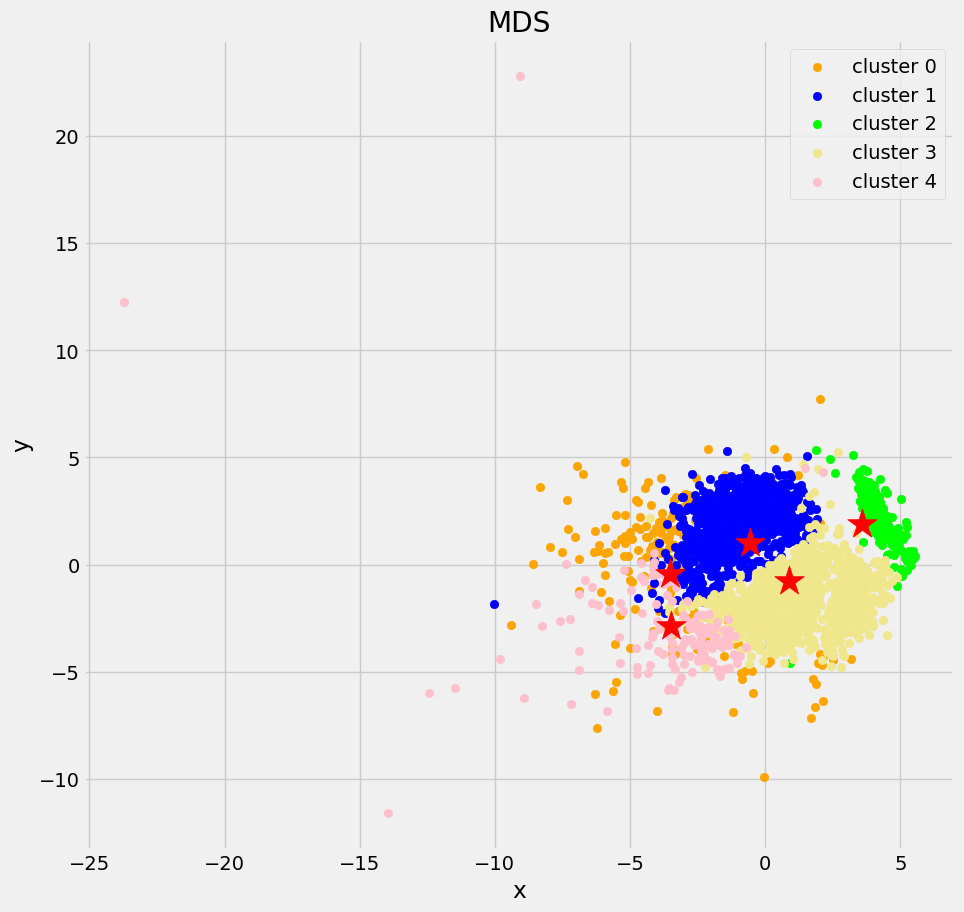

In [90]:
clustering_scatterplot(points=XYcoordinates[:-k,:],
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:],
                       title='MDS')

Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

In [91]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


In [92]:
XYcoordinates.shape

(2005, 2)

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

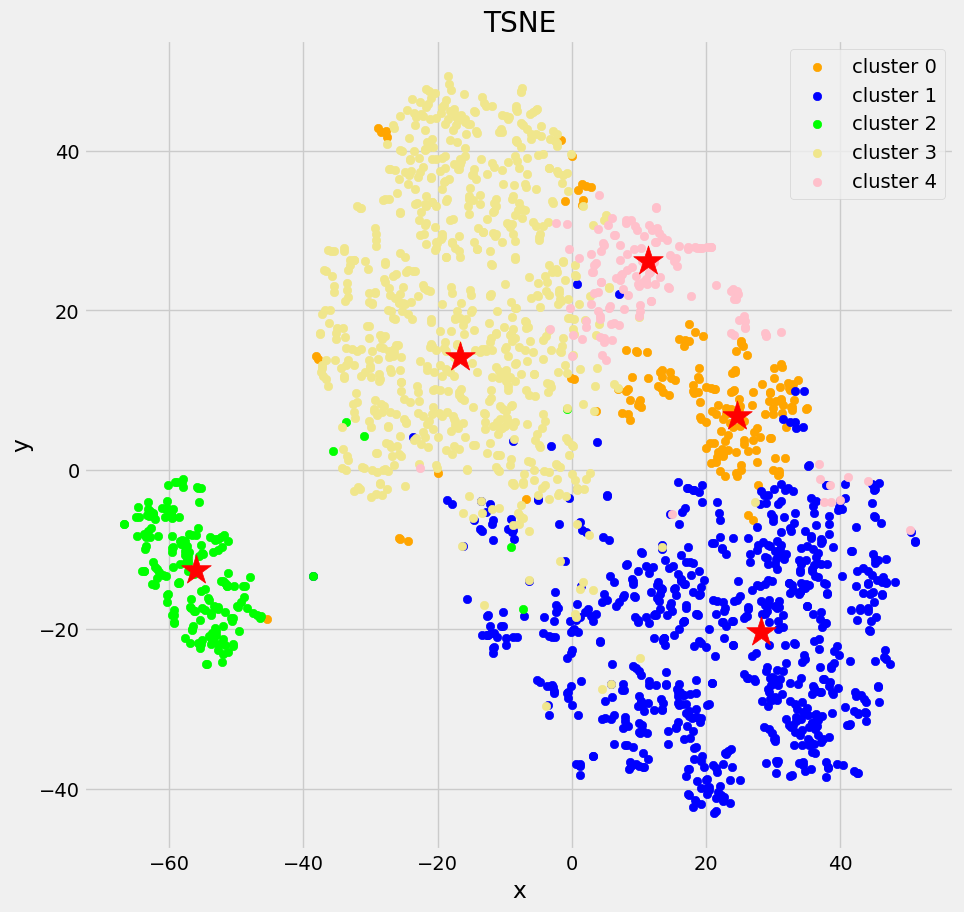

In [93]:
clustering_scatterplot(points=XYcoordinates[:-k,:],
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:],
                       title='TSNE')

Add the cluster labels as an extra column in the original dataframe

In [94]:
df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  duration  ...  previous  poutcome  subscribed   day_sin  day_cos  \
0  cellular       957  ...         2   failure          no  0.201299  0.97953   
1  cellular       233  ...         1   failure          no  0.201299  0.97953   
2  cellular       126  ...         1   failure          no  0.201299  0.97953   
3  cellular       274  ...         2   failure          no  0.201299  0.97953   
4  cellular       479  ...         1   failure          no  0.201299  0.97953   

   month_sin  month_cos  balancelog  durationlog  cluster  
0   0.866025       -0.5    7.224753     6.872128        1  
1   0.866025       -0.5    7.419980     5.484797        1  
2   0.866025       -0.5    7.608871     4.897840        1  
3   0.866025       -0.5    7.229114     5.641907        1  
4   0.866025       -0.5    7.593374     6.188264        1  

[5 rows x 22 columns]

In [95]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  duration  ...  previous  poutcome  subscribed   day_sin  \
1995   cellular       327  ...         0       NaN         yes -0.101168   
1996   cellular      1334  ...         0       NaN         yes -0.101168   
1997  telephone       231  ...         0       NaN         yes -0.299363   
1998        NaN       185  ...         0       NaN         yes -0.790776   
1999   cellular       208  ...         0       NaN         yes -0.968077   

       day_cos  month_sin     month_cos  balancelog  durationlog  cluster  
1995 -0.994869       -1.0 -1.836970e-16    8.233769     5.814131        3  
1996 -0.994869       -1.0 -1.836970e-16    7.010312     7.201916        3  
1997 -0.954139       -1.0 -1.836970e-16    7.666222     5.476464        3  
1998 -0.612106       -1.0 -1.836970e-16    8.579980     5.262690        2  
1999 -0.250653       -1.0 -1.836970e-16    8.907071     5.375278        3  

[5 rows x 22 columns]

Compute the mean value of each attribute for each cluster

In [96]:
df1 = pd.get_dummies(df, columns=['marital', 'education', 'housing', 'loan', 'contact','subscribed','poutcome'],
#                        dummy_na=True,
                        drop_first=True)
df1["marital_married"] = df1["marital_married"].astype(float)
df1["marital_single"] = df1['marital_single'].astype(float)
df1["education_secondary"] = df1["education_secondary"].astype(float)
df1["education_tertiary"] = df1['education_tertiary'].astype(float)
df1["subscribed_yes"] = df1['subscribed_yes'].astype(float)
df1["poutcome_other"] = df1['poutcome_other'].astype(float)
df1["poutcome_success"] = df1['poutcome_success'].astype(float)
df1["housing_yes"] = df1['housing_yes'].astype(float)
df1["loan_yes"] = df1['loan_yes'].astype(float)
df1["contact_telephone"] = df1['contact_telephone'].astype(float)
df2 = df1.drop(['job','default','day_sin','day_cos','month_sin','month_cos','balancelog','durationlog'],axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1988 non-null   float64
 1   balance              2000 non-null   int64  
 2   duration             2000 non-null   int64  
 3   campaign             2000 non-null   int64  
 4   pdays                2000 non-null   int64  
 5   previous             2000 non-null   int64  
 6   cluster              2000 non-null   int32  
 7   marital_married      2000 non-null   float64
 8   marital_single       2000 non-null   float64
 9   education_secondary  2000 non-null   float64
 10  education_tertiary   2000 non-null   float64
 11  housing_yes          2000 non-null   float64
 12  loan_yes             2000 non-null   float64
 13  contact_telephone    2000 non-null   float64
 14  subscribed_yes       2000 non-null   float64
 15  poutcome_other       2000 non-null   f

In [97]:
df2.groupby('cluster').mean()

age      balance    duration  campaign       pdays   previous  \
cluster                                                                        
0        41.886905  1584.511765  268.905882  5.341176  201.129412   3.429412   
1        41.224828  1016.213115  214.132514  1.523224  236.948087   2.169399   
2        38.478723   564.622340  225.005319  1.494681    7.808511   0.047872   
3        42.454427  1859.469520  384.334630  1.594034  133.935149   1.818418   
4        44.899281  1973.323741  309.057554  2.057554  168.503597  11.086331   

         marital_married  marital_single  education_secondary  \
cluster                                                         
0               0.535294        0.352941             0.441176   
1               0.598361        0.263661             0.558743   
2               0.579787        0.335106             0.510638   
3               0.496757        0.409857             0.456550   
4               0.647482        0.302158             0.453237   

         education_tertiary  housing_yes  loan_yes  contact_telephone  \
cluster                                                                 
0                  0.400000     0.523529  0.141176           0.105882   
1                  0.296448     0.747268  0.219945           0.062842   
2                  0.228723     0.803191  0.111702           0.005319   
3                  0.390402     0.154345  0.038911           0.088197   
4                  0.395683     0.410072  0.100719           0.093525   

         subscribed_yes  poutcome_other  poutcome_success  
cluster                                                    
0              0.376471        0.147059          0.158824  
1              0.062842        0.036885          0.006831  
2              0.122340        0.015957          0.005319  
3              0.989624        0.089494          0.453956  
4              0.748201        0.165468          0.438849

In [98]:
df2.groupby('cluster').count()

age  balance  duration  campaign  pdays  previous  marital_married  \
cluster                                                                       
0        168      170       170       170    170       170              170   
1        725      732       732       732    732       732              732   
2        188      188       188       188    188       188              188   
3        768      771       771       771    771       771              771   
4        139      139       139       139    139       139              139   

         marital_single  education_secondary  education_tertiary  housing_yes  \
cluster                                                                         
0                   170                  170                 170          170   
1                   732                  732                 732          732   
2                   188                  188                 188          188   
3                   771                  771                 771          771   
4                   139                  139                 139          139   

         loan_yes  contact_telephone  subscribed_yes  poutcome_other  \
cluster                                                                
0             170                170             170             170   
1             732                732             732             732   
2             188                188             188             188   
3             771                771             771             771   
4             139                139             139             139   

         poutcome_success  
cluster                    
0                     170  
1                     732  
2                     188  
3                     771  
4                     139

Conclusion for KMeans here TODO

Task 2 DBSCAN

In [99]:
from sklearn.cluster import DBSCAN

In [100]:
db = DBSCAN(eps=2.186, min_samples=10).fit(preprocessed_data)

In [101]:
preprocessed_data

array([[-3.85066599e-01, -1.37374795e-01,  1.49213404e+00, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       [ 5.82035337e-02,  1.07380157e-01, -1.34255741e-02, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       [ 9.85803268e-01,  3.44191918e-01, -6.50403231e-01, ...,
         9.79529941e-01,  8.66025404e-01, -5.00000000e-01],
       ...,
       [ 1.69591053e+00,  4.16093082e-01, -2.24691269e-02, ...,
        -9.54139256e-01, -1.00000000e+00, -1.83697020e-16],
       [ 4.28099391e-01,  1.56166931e+00, -2.54460269e-01, ...,
        -6.12105983e-01, -1.00000000e+00, -1.83697020e-16],
       [ 1.14933401e-01,  1.97174190e+00, -1.32277276e-01, ...,
        -2.50652532e-01, -1.00000000e+00, -1.83697020e-16]])

Code to help find good values for eps and min_samples manually

In [52]:
#j =0
#for i in range(db.labels_.size):
#  if db.labels_[i] > 0:
#    print(db.labels_[i])
#    j = j+1
#print(j)

In [102]:
data_and_labels = np.concatenate((preprocessed_data, db.labels_.reshape(-1, 1)), axis=1)

In [103]:
data_and_labels.shape

(2000, 24)

In [104]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_labels)
print("transformation complete")

transformation complete


In [106]:
XYcoordinates

array([[-2.05896962,  0.07478863],
       [ 1.36155178,  3.0718561 ],
       [ 0.36971132,  1.99870911],
       ...,
       [ 3.91393873,  0.46425165],
       [ 4.83970019,  2.12264726],
       [-0.67469336, -3.42478615]])

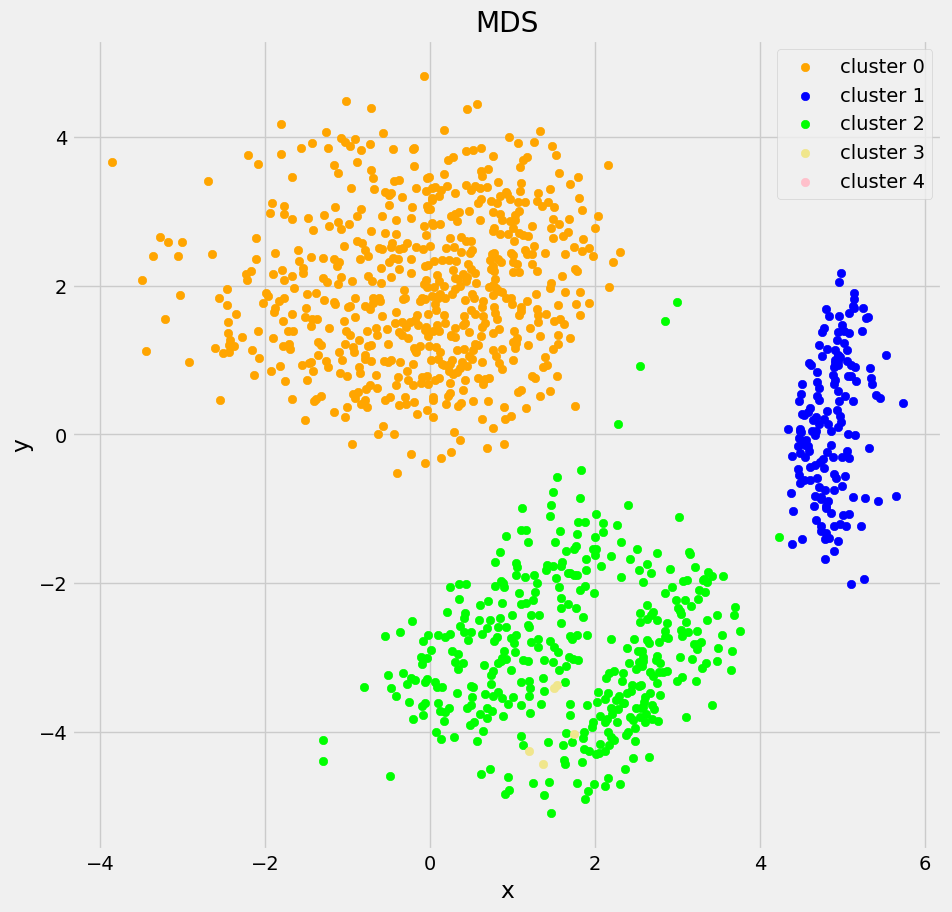

In [107]:
clustering_scatterplot(points=XYcoordinates[:,:],
                       labels=db.labels_,
                       centers=None,
                       title='MDS')

In [108]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_labels)
print("transformation complete")

transformation complete


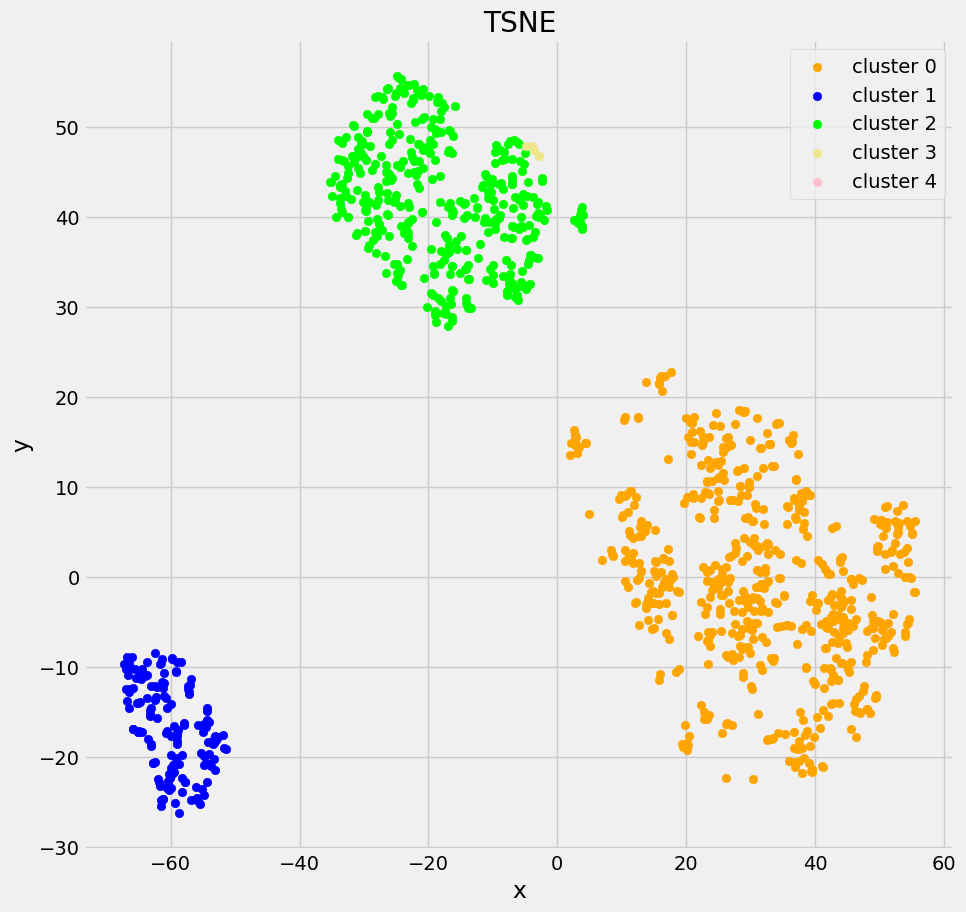

In [109]:
clustering_scatterplot(points=XYcoordinates[:,:],
                       labels=db.labels_,
                       centers=None,
                       title='TSNE')

In [110]:
df['cluster'] = pd.Series(db.labels_, index=df.index)
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  duration  ...  previous  poutcome  subscribed   day_sin  day_cos  \
0  cellular       957  ...         2   failure          no  0.201299  0.97953   
1  cellular       233  ...         1   failure          no  0.201299  0.97953   
2  cellular       126  ...         1   failure          no  0.201299  0.97953   
3  cellular       274  ...         2   failure          no  0.201299  0.97953   
4  cellular       479  ...         1   failure          no  0.201299  0.97953   

   month_sin  month_cos  balancelog  durationlog  cluster  
0   0.866025       -0.5    7.224753     6.872128       -1  
1   0.866025       -0.5    7.419980     5.484797        0  
2   0.866025       -0.5    7.608871     4.897840        0  
3   0.866025       -0.5    7.229114     5.641907        0  
4   0.866025       -0.5    7.593374     6.188264        0  

[5 rows x 22 columns]

In [111]:
df1 =df[['age','balance','cluster', 'duration', 'campaign', 'pdays', 'previous']]
df1.groupby('cluster').mean()

age      balance    duration  campaign       pdays  previous
cluster                                                                    
-1       44.660606  2239.199759  338.726835  2.441637  188.778580  3.776173
 0       41.044702   688.070608  204.876847  1.643678  230.678161  2.174056
 1       38.303797   524.069620  227.803797  1.455696   -1.000000  0.000000
 2       38.189394  1166.478589  353.732997  1.392947   95.604534  1.634761
 3       38.800000   324.400000  272.800000  1.200000  127.400000  2.400000

In [112]:
df1 = pd.get_dummies(df, columns=['marital', 'education', 'housing', 'loan', 'contact','subscribed','poutcome'],
#                        dummy_na=True,
                        drop_first=True)
df1["marital_married"] = df1["marital_married"].astype(float)
df1["marital_single"] = df1['marital_single'].astype(float)
df1["education_secondary"] = df1["education_secondary"].astype(float)
df1["education_tertiary"] = df1['education_tertiary'].astype(float)
df1["subscribed_yes"] = df1['subscribed_yes'].astype(float)
df1["poutcome_other"] = df1['poutcome_other'].astype(float)
df1["poutcome_success"] = df1['poutcome_success'].astype(float)
df1["housing_yes"] = df1['housing_yes'].astype(float)
df1["loan_yes"] = df1['loan_yes'].astype(float)
df1["contact_telephone"] = df1['contact_telephone'].astype(float)
df2 = df1.drop(['job','default','day_sin','day_cos','month_sin','month_cos','balancelog','durationlog'],axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1988 non-null   float64
 1   balance              2000 non-null   int64  
 2   duration             2000 non-null   int64  
 3   campaign             2000 non-null   int64  
 4   pdays                2000 non-null   int64  
 5   previous             2000 non-null   int64  
 6   cluster              2000 non-null   int64  
 7   marital_married      2000 non-null   float64
 8   marital_single       2000 non-null   float64
 9   education_secondary  2000 non-null   float64
 10  education_tertiary   2000 non-null   float64
 11  housing_yes          2000 non-null   float64
 12  loan_yes             2000 non-null   float64
 13  contact_telephone    2000 non-null   float64
 14  subscribed_yes       2000 non-null   float64
 15  poutcome_other       2000 non-null   f

In [113]:
df2.groupby('cluster').mean()

age      balance    duration  campaign       pdays  previous  \
cluster                                                                       
-1       44.660606  2239.199759  338.726835  2.441637  188.778580  3.776173   
 0       41.044702   688.070608  204.876847  1.643678  230.678161  2.174056   
 1       38.303797   524.069620  227.803797  1.455696   -1.000000  0.000000   
 2       38.189394  1166.478589  353.732997  1.392947   95.604534  1.634761   
 3       38.800000   324.400000  272.800000  1.200000  127.400000  2.400000   

         marital_married  marital_single  education_secondary  \
cluster                                                         
-1              0.522262        0.334537             0.416366   
 0              0.637110        0.244663             0.605911   
 1              0.626582        0.284810             0.512658   
 2              0.465995        0.508816             0.498741   
 3              1.000000        0.000000             0.200000   

         education_tertiary  housing_yes  loan_yes  contact_telephone  \
cluster                                                                 
-1                 0.377858     0.358604  0.120337           0.143201   
 0                 0.251232     0.799672  0.206897           0.029557   
 1                 0.234177     0.860759  0.107595           0.000000   
 2                 0.443325     0.105793  0.017632           0.022670   
 3                 0.800000     0.000000  0.000000           0.000000   

         subscribed_yes  poutcome_other  poutcome_success  
cluster                                                    
-1             0.726835        0.131167          0.302046  
 0             0.003284        0.018062          0.001642  
 1             0.012658        0.000000          0.000000  
 2             0.974811        0.065491          0.473552  
 3             1.000000        0.200000          0.800000

In [114]:
df2.groupby('cluster').count()

age  balance  duration  campaign  pdays  previous  marital_married  \
cluster                                                                       
-1       825      831       831       831    831       831              831   
 0       604      609       609       609    609       609              609   
 1       158      158       158       158    158       158              158   
 2       396      397       397       397    397       397              397   
 3         5        5         5         5      5         5                5   

         marital_single  education_secondary  education_tertiary  housing_yes  \
cluster                                                                         
-1                  831                  831                 831          831   
 0                  609                  609                 609          609   
 1                  158                  158                 158          158   
 2                  397                  397                 397          397   
 3                    5                    5                   5            5   

         loan_yes  contact_telephone  subscribed_yes  poutcome_other  \
cluster                                                                
-1            831                831             831             831   
 0            609                609             609             609   
 1            158                158             158             158   
 2            397                397             397             397   
 3              5                  5               5               5   

         poutcome_success  
cluster                    
-1                    831  
 0                    609  
 1                    158  
 2                    397  
 3                      5

TODO conclusion here